# Face Generation
Use generative adversarial networks to generate new images of faces.

### Get the Data
Two datasets will be used:
- [MNIST](http://yann.lecun.com/exdb/mnist/)
- [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

Since the CelebA dataset is complex, we'll test the neural network on MNIST before CelebA. Running the GANs on MNIST will allow us to see how well the model trains sooner.

In [1]:
data_dir = './data'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits.

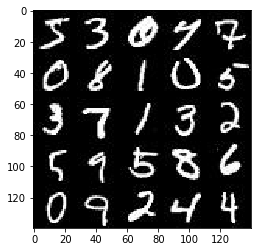

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.

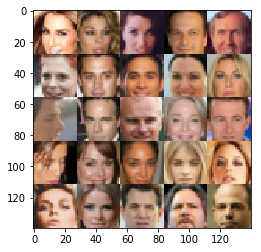

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).

## Build the Neural Network

### Check the Version of TensorFlow and Access to GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/luli/miniconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network.

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, (None), name = 'learn_rate')
    return inputs_real, inputs_z, learn_rate

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.

In [6]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer =tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(x1)
        relu1 = tf.nn.dropout(relu1, 0.9)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer =tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        relu2 = tf.nn.dropout(relu2, 0.9)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer =tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)

        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)        
        return out, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train

    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
      
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same', kernel_initializer =tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer =tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same', kernel_initializer =tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = leaky_relu(x4)

        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same', kernel_initializer =tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)       
        return out

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """  
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. 

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        
    return d_opt, g_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training.

In [10]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs using the following functions:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """   
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
        
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)       
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)  
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    

    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epochs in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                                 
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epochs+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    show_generator_output(sess=sess, image_mode=data_image_mode, input_z=input_z, n_images=9, out_channel_dim=image_channels)               

### MNIST
Test GANs architecture on MNIST. 

Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.9499


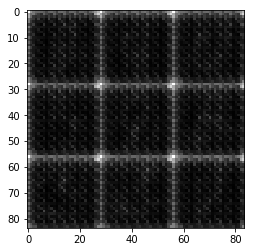

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 1.1693


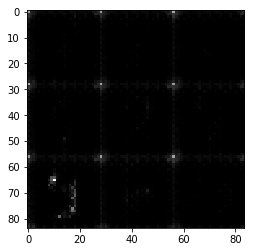

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8352


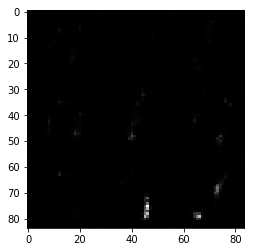

Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6163


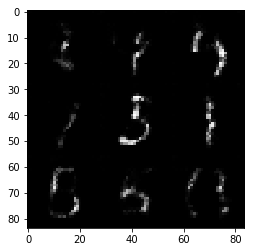

Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.6695


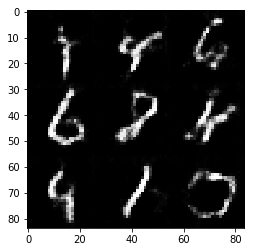

Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.0265


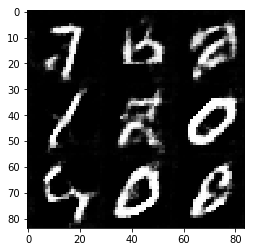

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.5175


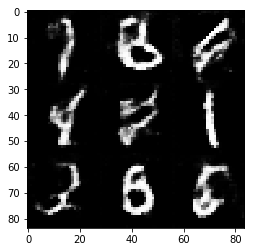

Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8026


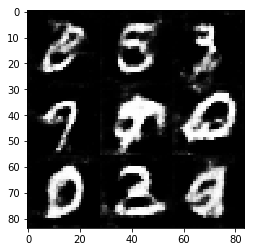

Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.9164


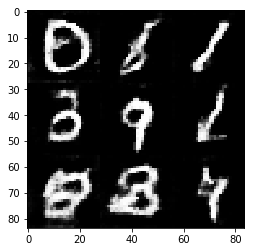

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2

epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run GANs on CelebA. 

Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 1.2686


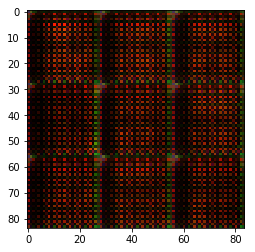

Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.9666


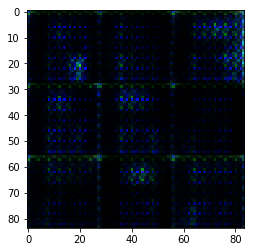

Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 1.1266


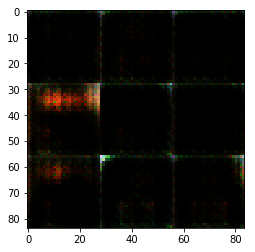

Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.9072


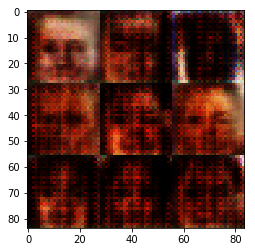

Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.6127


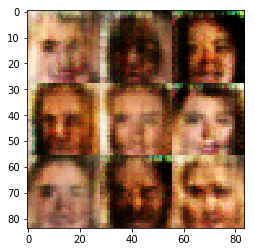

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.5793


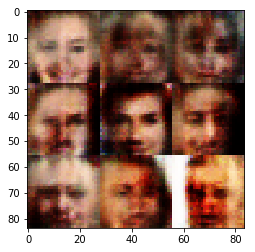

Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.8903


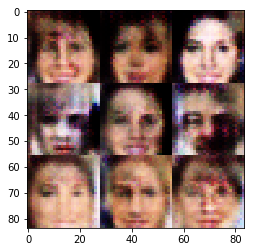

Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7476


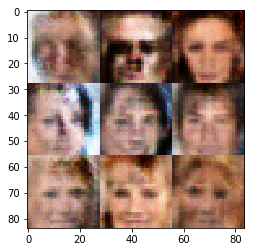

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7720


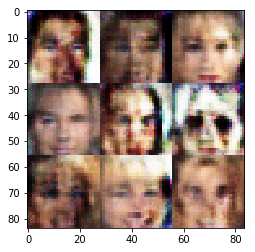

Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.9396


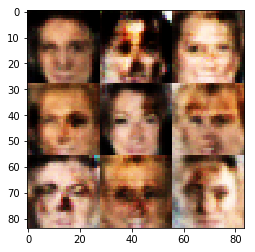

Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8136


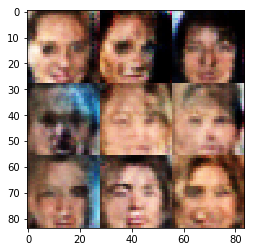

Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6437


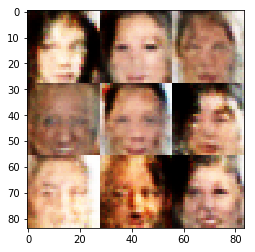

Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6121


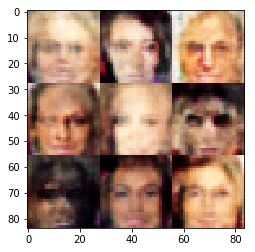

Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.8909


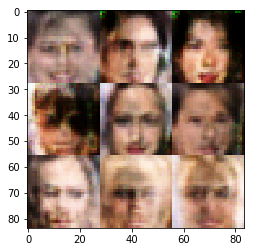

Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8020


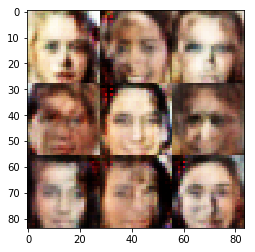

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 1.0091


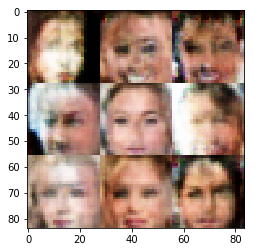

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8518


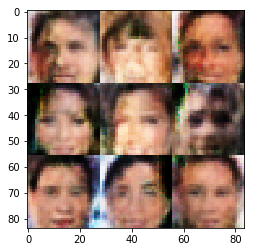

Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.5888


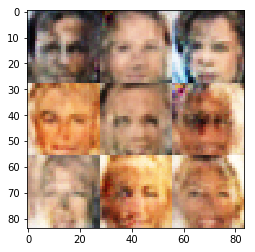

Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7864


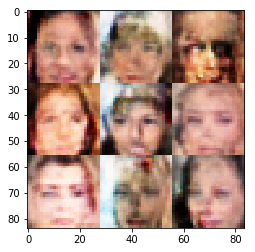

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.9920


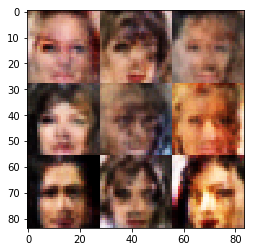

Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.7512


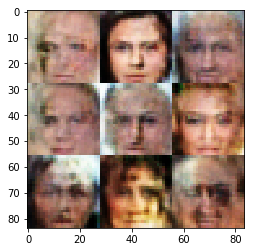

Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.8360


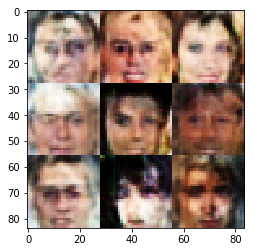

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.9743


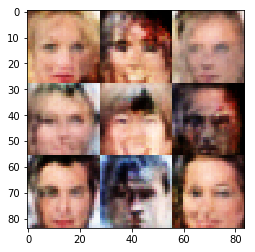

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.8512


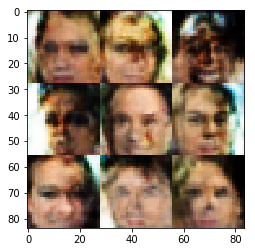

Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.8183


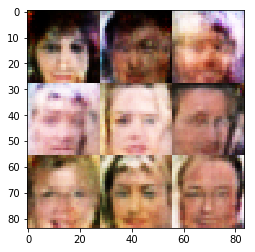

Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6625


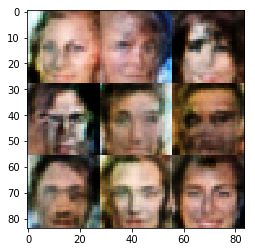

Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7707


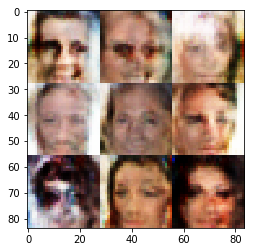

Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7808


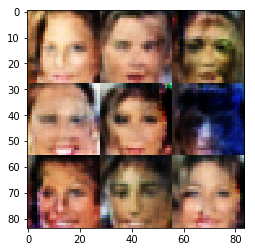

Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 1.2250


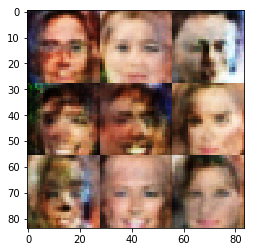

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6186


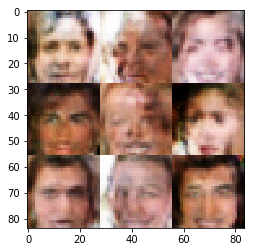

Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8279


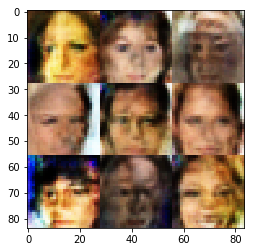

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)